# CS 6140 Machine Learning: Assignment - 1 (Total Points: 100)
## Prof. Ahmad Uzair 

### Q1. Decision Tree Classifier (50 points)

### Q1.1 Growing Decison Trees from scratch (40 points)

Decision Trees (DTs) are a non-parametric supervised learning method used for classification and regression. The goal of this question in the assignment is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. 
You must also print the Decision Tree. Use information gain based on entropy as the splitting measure. 

Use the data.csv dataset for this particular question. The dataset should be uploaded on Canvas with Assignment 1. Split the dataset into training and test data and calculate testing accuracy.



In [125]:
import pandas as pd
import numpy as np
import math
import pprint

def createDecisionTree(data, depth=0):
    '''
    Recursively creates a decision tree of nodes based on a data set.
    Assumes the last column in the dataset is the dependent variable/label.
    Each node will look like this:
        node: {
            _values: {},
            featureName: xxxxx,
            isLeaf: False/True,
            entropy: x,
            informationGain: x,
            splitVal: x,
            leftNode: {},
            rightNode: {},
            prediction: x, (if isLeaf == True)
        }
    '''
    # 0. instantiate this node
    node = {}
    # get the counts of each label value
    node["_values"] = dict(data["class"].value_counts())
    entropy = getEntropy(data)
    node['entropy'] = entropy
    node["isLeaf"] = False

    # Base case 1 - stop when tree height = 3
    if depth + 1 > 3:
        node["isLeaf"] = True

    # Base case 2:  if entropy < 0.1 -> this is a Leaf node (no more splits required)
    if entropy < 0.1:
        node["isLeaf"] = True

    # Base case 3: there are no features (data contains only the "class" column)
    if len(list(data.columns)) == 1:
        node["isLeaf"] = True

    # Base case 4: If there are < 3 rows -> use mode()[0]
    if len(data) < 3:
        node["isLeaf"] = True

    #  If leaf node == True, make a prediction and return the node
    if node['isLeaf'] == True:
        # predict the most frequntly occuring value
        node['prediction'] = data["class"].mode().tolist()[0]
        return node

    # 2. Look at all features and decide the best way to split the data into two subgroups
    bestSplit = getBestSplit(data)
    node["featureName"] = bestSplit["featureName"]
    node["informationGain"] = getInformationGain(data, bestSplit)
    node["splitVal"] = bestSplit["splitVal"]

    # 3. Create each branch using the data from each split

    # 3a. Create Left Branch
    leftNodeData = data.loc[data[bestSplit["featureName"]]
                            < bestSplit["splitVal"]]  # filter: only data < splitVal for left branch

    # Optional... allows you to split on a feature only once
    # leftNodeData = leftNodeData.drop(node["featureName"], axis=1)

    node["leftNode"] = createDecisionTree(leftNodeData, depth+1)

    # 3b. Right branch
    rightNodeData = data.loc[data[bestSplit["featureName"]]
                             >= bestSplit["splitVal"]]  # filter: only data >= splitVal for right branch

    # Optional... allows you to split on a feature only once
    # rightNodeData = rightNodeData.drop(node["featureName"], axis=1)

    node["rightNode"] = createDecisionTree(rightNodeData, depth+1)

    return node


def getEntropy(data):
    '''
    Returns the entropy (between 0 and 1) of the data. Input "data" is a dataframe.
    '''
    # Get the number of unique output values
    uniqueVals = data.iloc[:, -1].value_counts()

    # For each unique output value, calculate the entropy and sum them
    if len(uniqueVals) == 1:  # there is only one "class" value -> entropy = 0
        return 0
    entropy = 0  # initialize entropy to 0
    for val in uniqueVals.index.tolist():
        # get the probability "p" by dividing count of "val" by total count
        p = uniqueVals[val] / len(data)
        # add weighted entropy fraction to entropy
        # use log base 2 since there are 2 "class" values
        entropy += -(p*math.log(p, 2))
    return entropy


def getBestSplit(data):
    '''
    Returns an object containing the best way to split the data:
    {   
     featureName: "xxxx",
     splitVal: x,
     expEntropy: x,
    }
    '''
    features = data.columns[:-1].tolist()  # get list of feature names
    # instantiate bestSplit as placeholder with first feature, first row of data
    bestSplit = {
        "featureName": features[0],  # first feature name as placeholder
        # first row of data as placeholder
        "splitVal": data[features[0]].tolist()[0],
        "expEntropy": getExpectedEntropy(data, features[0], data[features[0]].tolist()[0]),
    }
    # Find the actual bestSplit
    for feature in features:
        # find the best value to split the data which minimizes expected entropy
        expectedEntropy = 1  # start by assuming highest entropy
        for value in data[feature].tolist():  # for every value for the target feature
            # get expected entropy
            EE = getExpectedEntropy(data, feature, value)
            if EE < expectedEntropy:  # update bestSplit if EE is less than expectedEntropy
                bestSplit["featureName"] = feature
                bestSplit["splitVal"] = value
                bestSplit["expEntropy"] = EE
                expectedEntropy = EE
    return bestSplit


def getExpectedEntropy(data, featureName, value):
    '''
    Returns the expected entropy if the data is split by featureName into 2 groups (1 < value, 2 >= value)
    '''

    dataset1 = data.loc[data[featureName] < value]
    dataset2 = data.loc[data[featureName] >= value]
    weight1 = len(dataset1) / len(data)
    weight2 = len(dataset2) / len(data)
    if weight1 == 0:  # if weight1 = 0, there are no rows where the feature value < the parameter "value"
        entropy2 = getEntropy(dataset2)
        return entropy2

    if weight2 == 0:  # if weight2 = 0, there are no rows where the feature value >= the parameter "value"
        entropy1 = getEntropy(dataset1)
        return entropy1

    entropy1 = getEntropy(dataset1)
    entropy2 = getEntropy(dataset2)
    return entropy1*weight1 + entropy2*weight2  # return weighted entropy


def getInformationGain(data, feature):
    '''
    Returns the information gain of the data if split by the parameter "feature".
    Assume the parameter "feature" is an object that has a key titled "expEntropy" (expected entropy
    for that feature must already be calculated).
    '''
    expectedEntropy = feature["expEntropy"]
    entropy = getEntropy(data)
    infoGain = entropy - expectedEntropy
    return infoGain


def printConciseTree(tree, indent):
    """
    Function to print the tree concisely (without all node keys) using pre-order traversal.
    """
    if tree["isLeaf"] == True:
        print("Prediction = " + str(tree["prediction"]))

    else:
        print("X " + str(tree["featureName"]), "<",
              tree["splitVal"], "?", tree["informationGain"])
        print("%sleft:" % (indent), end=" ")
        printConciseTree(tree["leftNode"], indent + indent)
        print("%sright" % (indent), end=" ")
        printConciseTree(tree["rightNode"], indent + indent)


def printFullTree(tree):
    '''
    Prints the decision tree in full (shows all node key/value pairs)
    '''
    pprint.pprint(tree)


def getIndex(featureName):
    if featureName == "feature1":
        return 0
    if featureName == "feature2":
        return 1
    if featureName == "feature3":
        return 2
    if featureName == "feature4":
        return 3


def predictClass(x, tree):
    '''
    Recursive function to predict the "class" (dependent variable) based on
    one observation containing 4 independent features.
    '''
    if tree["isLeaf"] == True:
        return tree["prediction"]
    else:
        # Get feature name at top of tree
        splitIndex = getIndex(tree["featureName"])
        # If the value is less than split index -> go left, else go right
        if x[splitIndex] < tree["splitVal"]:
            return predictClass(x, tree["leftNode"])
        else:
            return predictClass(x, tree['rightNode'])


def predictDataSet(tree, dataset):
    '''
    Returns a list of predictions besed on an input dataset. "dataset" is a
    matrix of n observations, each with 4 independent features
    '''
    predictions = []  # initialize predictions list
    # For each row, add a prediction to "predictions"
    for rowIndex in range(len(dataset)):
        predictions.append(predictClass(dataset.iloc[rowIndex], tree))
    return predictions


def getTestingAccuracy(tree, dataset):
    '''
    Returns the accuracy of the tree based on a set of independent features (X).
    1. Calculate a predicted Y for each instance of X
    2. Determine the % of correct Y values vs. % of wrong Y values
    '''
    right = 0
    total = 0
    predictions = predictDataSet(tree, dataset)
    for n in range(len(predictions)):
        if predictions[n] == dataset.iloc[n, dataset.columns.get_loc("class")]:
            right += 1
        total += 1
    return float(right/total)


def getTrainingTestData(data, testPercent):
    '''
    Returns the training and test data.
    '''
    from sklearn.model_selection import train_test_split
    x_data = data.iloc[:, :-1]
    y_data = data.iloc[:, -1]
    x_train, x_test, y_train, y_test = train_test_split(
        x_data, y_data, test_size=testPercent)
    test_data = pd.concat([x_test, y_test], axis=1)
    train_data = pd.concat([x_train, y_train], axis=1)
    return test_data, train_data


# Get data from CSV
data = pd.read_csv("data.csv")

# Split data into training and test data
testPercent = 0.2
testData, trainData = getTrainingTestData(data, testPercent)

# Create and print tree
tree = createDecisionTree(trainData)
printConciseTree(tree, "--")

accuracy = getTestingAccuracy(tree, testData)
print("Accuracy = " + str(accuracy))


X feature4 < 1.0 ? 0.9340680553754911
--left: Prediction = 0
--right X feature4 < 1.7 ? 0.7164618762478255
----left: X feature4 < 1.4 ? 0.0988899338057529
--------left: Prediction = 1
--------right Prediction = 1
----right X feature4 < 1.9 ? 0.04859480054624993
--------left: Prediction = 2
--------right Prediction = 2
Accuracy = 0.9333333333333333


### Q1.2 Decision Tree using Sklearn Library (10 points)

Use the Decision Tree Classifier from the Sklearn Library and use gini index as a splitting measure. Use the data.csv dataset.
Calculate accuracy for this model. 
Print the Decision tree and compare the Decision Trees generated from your code and Sklearn.

### Q2 Linear Regression (40 points)

Linear regression attempts to model the relationship between two variables by fitting a linear equation to observed data. One variable is considered to be an explanatory variable, and the other is considered to be a dependent variable. 
<br>


## Gradient descent algorithm 
\begin{equation}
\theta^{+} = \theta^{-} + \frac{\alpha}{m} (y_{i} - h(x_{i}) )\bar{x}
\end{equation}

This minimizes the following cost function

\begin{equation}
J(x, \theta, y) = \frac{1}{2m}\sum_{i=1}^{m}(h(x_i) - y_i)^2
\end{equation}

where
\begin{equation}
h(x_i) = \theta^T \bar{x}
\end{equation}

In [114]:
# Do not change the code in this cell
true_slope = 15
true_intercept = 2.4
input_var = np.arange(0.0,100.0)
output_var = true_slope * input_var + true_intercept + 300.0 * np.random.rand(len(input_var))


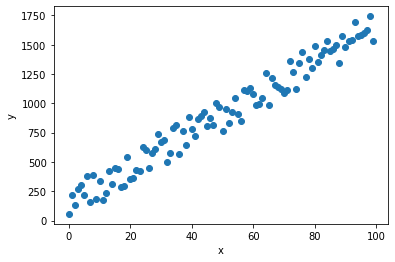

In [115]:
# Do not change the code in this cell
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(input_var, output_var)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [116]:
def compute_cost(ip, op, params):
    """
    Cost function in linear regression where the cost is calculated
    ip: input variables
    op: output variables
    params: corresponding parameters
    Returns cost
    """
    num_samples = len(ip)
    cost_sum = 0.0
    for x,y in zip(ip, op):
        y_hat = np.dot(params, np.array([1.0, x]))
        cost_sum += (y_hat - y) ** 2
    
    cost = cost_sum / (num_samples)
    
    return cost

### Q2.1 Implement Linear Regression using Batch Gradient Descent from scratch.  (15 points)


### Batch gradient descent
Algorithm can be given as follows:

```for j in 0 -> max_iteration: 
    for i in 0 -> m: 
        theta += (alpha / m) * (y[i] - h(x[i])) * x_bar
```

In [117]:
def updateParams(params, alpha, ip, op):
    '''
    Updates the params vector
    '''
    num_samples = len(ip)

    sumErrorsW0 = 0.0
    for x, y in zip(ip, op):
        y_hat = np.dot(params, np.array([1.0, x]))
        sumErrorsW0 += (y_hat - y)
    print("sumError = " + str(sumErrorsW0))

    sumErrorsW1 = 0.0
    for x, y in zip(ip, op):
        y_hat = np.dot(params, np.array([1.0, x]))
        sumErrorsW1 += ((y_hat - y))*x
    # print("sumErrorX = " + str(sumErrorsW1))

    params[0] = params[0] - alpha*(sumErrorsW0)/num_samples
    params[1] = params[1] - alpha*(sumErrorsW1)/num_samples



def linear_regression_using_batch_gradient_descent(ip, op, params, alpha, max_iter):
    """
    Compute the params for linear regression using batch gradient descent
    ip: input variables
    op: output variables
    params: corresponding parameters
    alpha: learning rate
    max_iter: maximum number of iterations
    Returns parameters, cost, params_store
    """ 
    # initialize iteration, number of samples, cost and parameter array
    iteration = 0
    num_samples = len(ip)
    cost = np.zeros(max_iter)
    params_store = np.zeros([2, max_iter]) # two arrays, each with 100 zeros
    
    # Compute the cost and store the params for the corresponding cost
    while iteration < max_iter:
        cost[iteration] = compute_cost(ip, op, params) # get the SSE for the current set of params
        params_store[:, iteration] = params  # save the current params in the param store
        
        print('--------------------------')
        print(f'iteration: {iteration}')
        print(f'cost: {cost[iteration]}')
        
        # Apply batch gradient descent
        updateParams(params, alpha, ip, op)
        
        iteration += 1
        
    
    return params, cost, params_store

--------------------------
iteration: 0
cost: 12017227.471580923
sumError = 235524.9438917994
--------------------------
iteration: 1
cost: 5785007.10482545
sumError = 162515.8003423887
--------------------------
iteration: 2
cost: 2787993.6744912826
sumError = 111886.7236630616
--------------------------
iteration: 3
cost: 1346759.356501072
sumError = 76777.38248789491
--------------------------
iteration: 4
cost: 653683.8716188271
sumError = 52430.39477277335
--------------------------
iteration: 5
cost: 320390.5917560152
sumError = 35546.69481569671
--------------------------
iteration: 6
cost: 160113.0263682062
sumError = 23838.504505681532
--------------------------
iteration: 7
cost: 83037.01191533529
sumError = 15719.335679754264
--------------------------
iteration: 8
cost: 45971.80283652965
sumError = 10089.018404838147
--------------------------
iteration: 9
cost: 28147.395509009628
sumError = 6184.626168214971
--------------------------
iteration: 10
cost: 19575.70001007926


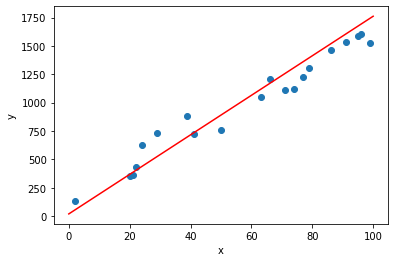

In [118]:
# Do not change the code in this cell
# Training the model
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(input_var, output_var, test_size=0.20)

params_0 = np.array([20.0, 80.0])

alpha_batch = 1e-4 # I updated this to 1e-4. The original value of 1e-3 was too small.
max_iter = 50
params_hat_batch, cost_batch, params_store_batch =\
    linear_regression_using_batch_gradient_descent(x_train, y_train, params_0, alpha_batch, max_iter)
print(len(params_store_batch))


plt.figure()
plt.scatter(x_test, y_test)
plt.xlabel('x')
plt.ylabel('y')
# Add line to scatter
X_plot = np.linspace(0, 100, 2000)
Y_plot = params_hat_batch[1]*X_plot+params_hat_batch[0]
plt.plot(X_plot, Y_plot, color='r')
plt.show()


### Q2.2 Implement Stochastic Gradient Descent from scratch. (15 points)

### Stochastic Gradient Descent
Algorithm can be given as follows:
```shuffle(x, y)
for i in 0 -> m:
    theta += (alpha / m) * (y[i] - h(x[i])) * x_bar  
```

In [119]:
def updateParamsStochastic(params, alpha, x, y, i):
    '''
    Updates the params vector via stochastic method
    '''
    m = len(x)
    y_hat = np.dot(params, np.array([1.0, x[i]]))
    error = y_hat - y[i]
    params[0] = params[0] - (alpha * error / m)
    params[1] = params[1] - (alpha * error / m * x[i])


def lin_reg_stoch_gradient_descent(ip, op, params, alpha):
    """
    Compute the params for linear regression using stochastic gradient descent
    ip: input variables
    op: output variables
    params: corresponding parameters
    alpha: learning rate
    Returns parameters, cost, params_store
    """

    # run SGD for a set number of epochs
    max_epochs = 20
    epoch = 0
    
    # initialize number of samples, cost and parameter array
    num_samples = len(input_var)
    cost = np.zeros(max_epochs)
    params_store = np.zeros([2, num_samples])

    while epoch < max_epochs:
        i = 0
        # Compute the cost and store the params for the corresponding cost
        for x, y in zip(input_var, output_var):
            # cost[i] = compute_cost(input_var, output_var, params)
            # Apply stochastic gradient descent
            updateParamsStochastic(params, alpha, input_var, output_var, i)
            i += 1  # i will increment until i == len(op)
        
        print('--------------------------')
        print(f'iteration: {epoch}')
        print(f'cost: {cost[epoch]}')

        params_store[:, epoch] = params
        cost[epoch] = compute_cost(input_var, output_var, params)
        epoch += 1

    return params, cost, params_store

--------------------------
iteration: 0
cost: 0.0
--------------------------
iteration: 1
cost: 0.0
--------------------------
iteration: 2
cost: 0.0
--------------------------
iteration: 3
cost: 0.0
--------------------------
iteration: 4
cost: 0.0
--------------------------
iteration: 5
cost: 0.0
--------------------------
iteration: 6
cost: 0.0
--------------------------
iteration: 7
cost: 0.0
--------------------------
iteration: 8
cost: 0.0
--------------------------
iteration: 9
cost: 0.0
--------------------------
iteration: 10
cost: 0.0
--------------------------
iteration: 11
cost: 0.0
--------------------------
iteration: 12
cost: 0.0
--------------------------
iteration: 13
cost: 0.0
--------------------------
iteration: 14
cost: 0.0
--------------------------
iteration: 15
cost: 0.0
--------------------------
iteration: 16
cost: 0.0
--------------------------
iteration: 17
cost: 0.0
--------------------------
iteration: 18
cost: 0.0
--------------------------
iteration: 19


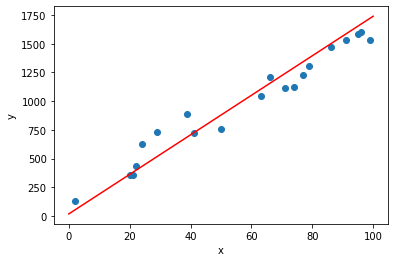

In [120]:
# Do not change the code in this cell
alpha = 1e-4
params_0 = np.array([20.0, 80.0])
params_hat, cost, params_store =\
lin_reg_stoch_gradient_descent(x_train, y_train, params_0, alpha)


plt.figure()
plt.scatter(x_test, y_test)
plt.xlabel('x')
plt.ylabel('y')
# Add line to scatter
X_plot = np.linspace(0, 100, 2000)
Y_plot = params_hat[1]*X_plot+params_hat[0]
plt.plot(X_plot, Y_plot, color='r')
plt.show()

### Q2.3 Calculate Root Mean Square error in batch gradient descent algorithm and stochastic gradient descent algorithm (5 points)

In [121]:
# Calculate Root Mean Square error in batch gradient descent algorithm and stochastic gradient descent algorithm

# ___BATCH___
# params_hat_batch
# We calculated the "cost" above which is the Sum of Squared Errors
MSE_batch = cost_batch[-1].mean()   
RMSE_batch = math.sqrt(MSE_batch)
print(RMSE_batch)


# STOCHASTIC
MSE = cost[-1].mean()   
RMSE = math.sqrt(MSE)
print(RMSE)



107.82746773206816
109.944836371122


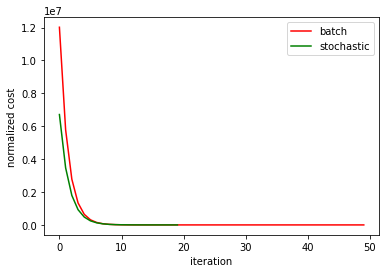

min cost with BGD: 11626.7627975102
min cost with SGD: 12087.867044672788


In [122]:
# Do not change the code in this cell
plt.figure()
plt.plot(np.arange(max_iter), cost_batch, 'r', label='batch')
plt.plot(np.arange(len(cost)), cost, 'g', label='stochastic')
plt.xlabel('iteration')
plt.ylabel('normalized cost')
plt.legend()
plt.show()
print(f'min cost with BGD: {np.min(cost_batch)}')
print(f'min cost with SGD: {np.min(cost)}')

### Q2.4 Which linear regression model do you think works best for this data? Explain in brief. (5 points)

For this dataset, I think using batch gradient descent works best. The data is small which means using batch is not computationally prohibitive: the dataset includes only two features (param[0] and param[1]) and only 100 instances. We can therefore reach the optimal solution quickly with batch. Using stochastic gradient descient achieves a similar result to batch after 5 epochs(SGD) and 5 iterations(BGD).

### Q3. Linear Regression Analytical Problem (10 points)
Consider the following training data.

| X1 | X2 | Y |
| -- | -- | -- |
| 0 | 0 | 0 |
| 0 | 1 | 1.5 |
| 1 | 0 | 2 |
| 1 | 1 | 2.5 |
Suppose the data comes from a model y = $θ_{0}$ +$θ_{1}$x1 +$θ_{2}$x2 for unknown constants $θ_{0}$,$θ_{1}$,$θ_{2}$. Use least squares linear regression to find an estimate of $θ_{0}$,$θ_{1}$,$θ_{2}$.

In [123]:
data = pd.DataFrame({"x0": [1, 1, 1, 1], "x1": [0, 0, 1, 1], "x2": [
                    0, 1, 0, 1], "y": [0.0, 1.5, 2.0, 2.5]})  # x0 is all zeros
theta = [0, 0, 0]  # theta is our function. Initialize theta with zeros


def getSumSquareErrors(data, theta):
    '''
    Returns the sum of squared errors by comparing y to the dot product of
    '''
    SSE = 0

    for index, row in data.iterrows():
        y_hat = row["x0"]*theta[0] + row["x1"] * \
            theta[1] + row["x2"]*theta[2]
        y = row["y"]
        SSE += (y - y_hat)**2
    return SSE


def adjustTheta(theta, data, alpha, sampleCount):
    # update theta[0]
    sumErrors = 0
    for index, row in data.iterrows():
        x = row.values.tolist()[:-1]  # exclude "y" column
        y = row.values[-1]
        y_hat = np.dot(x, theta)
        # print("y_hat = " + str(y_hat) + ", y = " + str(y))
        sumErrors += (y_hat-y)
    theta[0] = theta[0] - alpha*sumErrors/sampleCount

    # updated theta[1-2]
    sumErrorsX = [0, 0, 0]
    for m in range(1, 3):
        for index, row in data.iterrows():
            x = row.values.tolist()[:-1]  # exclude "y" column
            y = row.values[-1]
            y_hat = np.dot(x, theta)
            sumErrorsX[m] += (y_hat-y)*x[m]

        theta[m] = theta[m] - alpha*sumErrorsX[m]/sampleCount


# Run the algorithm for set number of iterations to determine theta
iterations = 50
alpha = 0.1
sampleCount = len(data)
SSE_store = np.zeros(iterations) # store the sum of squared errors on each iteration
for iter in range(iterations):
    SSE = getSumSquareErrors(data, theta)
    SSE_store[iter] = SSE
    adjustTheta(theta, data, alpha, sampleCount)
    
# print(SSE_store)  # Optional: see the SSE on each iteration
# print("theta = " + str(theta)) # Optional: the full theta before rounding
print("theta = " + str(round(theta[0], 1)) + "X_0 + " + str(round(theta[1],1)) + "X_1 + " + str(round(theta[2],1)) + "X_2") # theta is our answer


theta = 0.6X_0 + 1.1X_1 + 0.8X_2
